In [1]:
%matplotlib inline



Training an PDBSS Classifier
=====
## Custom Dataset, Model Checkpointing, and Fine-tune

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

## 1. Custom Dataset
PyTorch has many built-in datasets such as MNIST and CIFAR. In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class. Use [this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true) to download the mnist png dataset.

In [3]:
class PDBSS_SURFACE(Dataset):
    """
    A customized data loader for PDBSS (PDB Snapshots Database).
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the PDBSS dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(740): #740 categories
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
            #image = transform.resize(image, (300,300))
            #image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
    

In [4]:
# Create the PDBSS dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]

data_transform = transforms.Compose([
        transforms.Resize(size=(300,300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0, 0.0, 0.0],
                             std=[0.25, 0.25, 0.25])
    ])

trainset = PDBSS_SURFACE(
    root='/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_SURFACE/train',
    preload=False, transform=data_transform,
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64*4, shuffle=True, num_workers=2)  #batch_size = original 64. ideally > 740.

# load the testset
testset = PDBSS_SURFACE(
    root='/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_SURFACE/test',
    preload=False, transform=data_transform,
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2) #batch_size = original 100

In [5]:
print(len(trainset))
print(len(testset))

305600
20736


In [6]:
trainset[0][0].size()

torch.Size([3, 300, 300])

### Visualize the dataset

tensor(134) tensor(154) tensor(51) tensor(504) tensor(373) tensor(637) tensor(504) tensor(324) tensor(273) tensor(635) tensor(572) tensor(359) tensor(452) tensor(83) tensor(549) tensor(663)


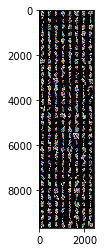

Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/sit

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

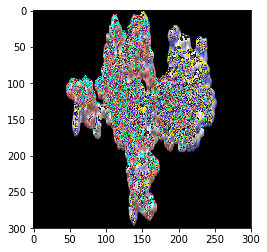

In [8]:
imshow(images[7])

In [9]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

cpu


### Define a Conv Net


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1,padding=1) #(300+1x2-3)/1+1=300  300x300x10 pool 150x150x10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=1,padding=1) #(150+1x2-3)/1+1=150  150x150x10 pool 75x75x20
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(75*75*20, 740*3)  #75x75x20 
        self.fc2 = nn.Linear(740*3, 740) #740 total categories

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 75*75*20) # reshape 75x75x20
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train the network

In [11]:
def train_old(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        
        correct = 0
        
        for batch_idx, (data, target) in enumerate(trainset_loader):
            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {}/{} ({:.0f}%)'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item(),
                    correct, len(data),
                    100. * correct / len(data) ))
                
            iteration += 1
            correct = 0
        test()

In [13]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))
    
    

In [14]:
#train(1)  # train 5 epochs should get you to about 97% accuracy  #note: this does not save model 


## 2. Save the model (model checkpointing)

Now we have a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [15]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state,checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)
    

In [16]:
# create a brand new model
#model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#test()



### Define a training loop with model checkpointing

In [17]:
def train_save_old(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    
    # save the first model
    save_checkpoint('pdbss-SURFACE-%i.pth' % iteration, model, optimizer)    
    
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('pdbss-SURFACE-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('pdbss-SURFACE-%i.pth' % iteration, model, optimizer)

def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0

    # save the first model
    save_checkpoint('pdbss-SURFACE-%i.pth' % iteration, model, optimizer)
    
    for ep in range(epoch):   

        correct = 0

        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()           
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {}/{} ({:.0f}%)'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item(),
                    correct, len(data),
                    100. * correct / len(data)))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('pdbss-SURFACE-%i.pth' % iteration, model, optimizer)
            iteration += 1
            correct = 0
        test()
    
    # save the final model
    save_checkpoint('pdbss-SURFACE-%i.pth' % iteration, model, optimizer)
    
    

In [18]:
train_save(10, 3000, 100) #each epoch has 4700 iterations. original train_save(5,500,100)


model saved to pdbss-SURFACE-0.pth
Train Epoch: 0 [0/305600 (0%)]	Loss: 6.613822 	Accuracy: 0/256 (0%)
Train Epoch: 0 [25600/305600 (8%)]	Loss: 4.691539 	Accuracy: 26/256 (10%)
Train Epoch: 0 [51200/305600 (17%)]	Loss: 4.625884 	Accuracy: 30/256 (12%)
Train Epoch: 0 [76800/305600 (25%)]	Loss: 4.305901 	Accuracy: 32/256 (12%)
Train Epoch: 0 [102400/305600 (34%)]	Loss: 4.503367 	Accuracy: 34/256 (13%)
Train Epoch: 0 [128000/305600 (42%)]	Loss: 4.309661 	Accuracy: 36/256 (14%)
Train Epoch: 0 [153600/305600 (50%)]	Loss: 4.187340 	Accuracy: 42/256 (16%)
Train Epoch: 0 [179200/305600 (59%)]	Loss: 4.059433 	Accuracy: 39/256 (15%)
Train Epoch: 0 [204800/305600 (67%)]	Loss: 4.222292 	Accuracy: 36/256 (14%)
Train Epoch: 0 [230400/305600 (75%)]	Loss: 4.081500 	Accuracy: 40/256 (16%)
Train Epoch: 0 [256000/305600 (84%)]	Loss: 3.654788 	Accuracy: 57/256 (22%)
Train Epoch: 0 [281600/305600 (92%)]	Loss: 4.066331 	Accuracy: 42/256 (16%)

Test set: Average loss: 6.3225, Accuracy: 732/20736 (4%)

Train 

Process Process-27:
Process Process-28:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/user/anaconda3/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/user/anaconda3/envs/cs231

KeyboardInterrupt: 

In [19]:
save_checkpoint('/Users/user/Documents/stanford_courses/cs231n/project/pytorch_cs231n/pdbss-SURFACE-%i.pth' % 100000, model, optimizer)

model saved to /Users/user/Documents/stanford_courses/cs231n/project/pytorch_cs231n/pdbss-SURFACE-100000.pth


In [21]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('model_bkup/pdbss-SURFACE-100000.pth', model, optimizer)
# should give you the final model accuracy
test()


model loaded from model_bkup/pdbss-SURFACE-100000.pth

Test set: Average loss: 22.3764, Accuracy: 2892/20736 (14%)



## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [ ]:
# What's in a state dict?
print(model.state_dict().keys())


### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [ ]:
checkpoint = torch.load('pdbss-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
train(1)  # training 1 epoch will get you to 93%!


### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model.

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1,padding=1) #(300+1x2-3)/1+1=300  300x300x10 pool 150x150x10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=1,padding=1) #(150+1x2-3)/1+1=150  150x150x10 pool 75x75x20
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(75*75*20, 740)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 75*75*20)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
checkpoint = torch.load('pdbss-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)


In [ ]:
train(1)  # training 1 epoch will get you to 93%!
